### Introduction

> Due to rapid growth in field of cashless or digital transactions, credit cards are widely used in all around the world. 
Credit cards providers are issuing thousands of cards to their customers. Providers have to ensure all the credit card users should be genuine 
and real. 

> Any mistake in issuing a card can be reason of financial crises. Due to rapid growth in cashless transaction, 
the chances of number of fraudulent transactions can also increasing. A Fraud transaction can be identified by analyzing various behaviors of credit card customers from previous transaction history datasets. If any deviation is noticed in spending behavior from available patterns, it is possibly of fraudulent transaction. 

> Data mining and machine learning techniques are widely used in credit card fraud detection. In this article we are presenting review of various data mining and machine learning methods which are widely used for credit card fraud detections and complete this project end to end from Data Understanding to deploy Model via API .


### Import necessary libraries

In [70]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import average_precision_score, plot_confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
import warnings
import optuna 
from joblib import Parallel, delayed
import joblib 
from sklearn import set_config
from typing import List, Optional, Union
set_config(display='diagram')
warnings.filterwarnings('ignore')
from xgboost import plot_importance, to_graphviz

In [71]:
data = pd.read_csv('transactions_train.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


- Checking for missing and duplicate data

In [72]:
data.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrig    False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
dtype: bool

In [73]:
data.duplicated().sum()

0

In [74]:
data.describe()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.351193e+06,6.351193e+06,6.351193e+06,6.351193e+06,6.351193e+06,6.351193e+06,6.351193e+06
mean,2.425553e+02,1.798155e+05,8.347957e+05,8.561696e+05,1.101043e+06,1.225372e+06,1.215047e-03
std,1.410676e+02,6.036310e+05,2.889959e+06,2.926073e+06,3.398924e+06,3.674293e+06,3.483635e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.550000e+02,1.338829e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.380000e+02,7.486483e+04,1.415300e+04,0.000000e+00,1.330865e+05,2.149190e+05,0.000000e+00
75%,3.340000e+02,2.087152e+05,1.073460e+05,1.443651e+05,9.438661e+05,1.112791e+06,0.000000e+00
max,6.990000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [75]:
data['isFraud'].value_counts()

0    6343476
1       7717
Name: isFraud, dtype: int64

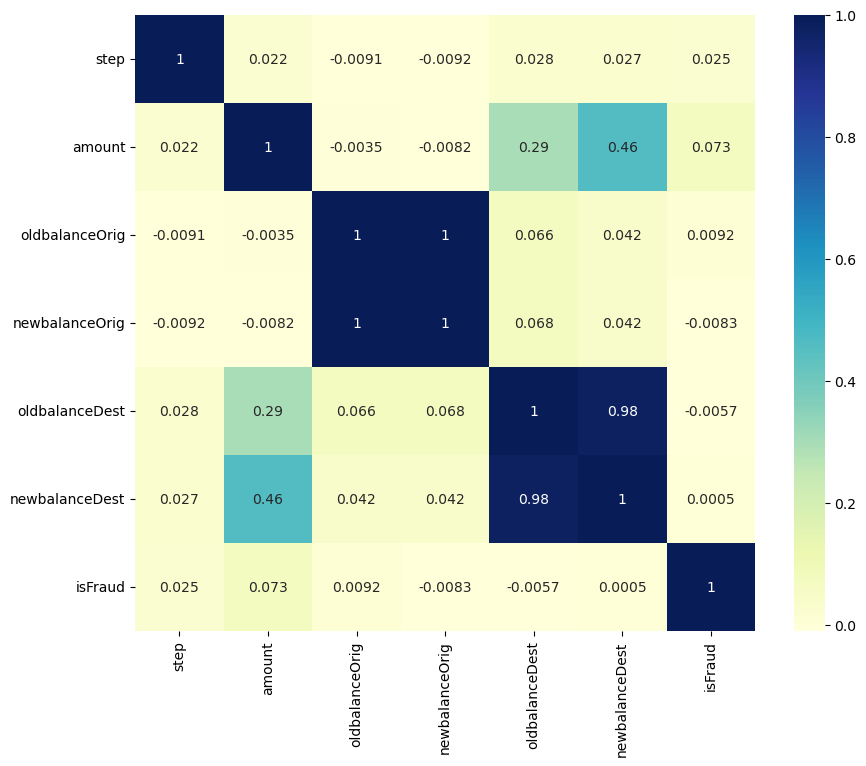

In [76]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

<Figure size 1000x800 with 0 Axes>

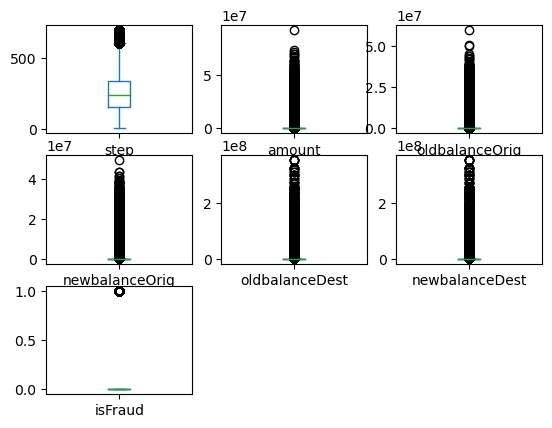

In [77]:
plt.figure(figsize=(10, 8))
data.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()

array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'oldbalanceOrig'}>],
       [<AxesSubplot:title={'center':'newbalanceOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>,
        <AxesSubplot:title={'center':'newbalanceDest'}>],
       [<AxesSubplot:title={'center':'isFraud'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

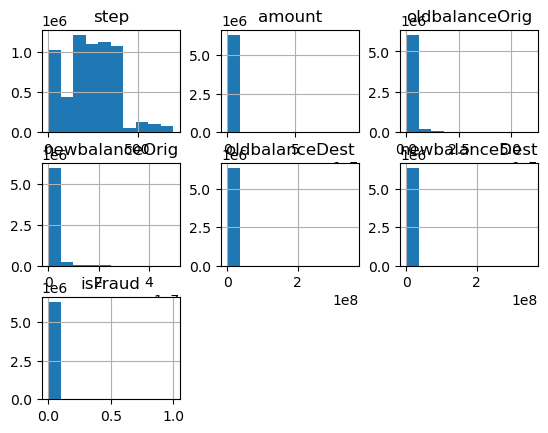

In [78]:
data.hist()

### Exploratory Data Analysis

> Which transactions are fraudulent?

>- It was discovered that of the five types of transactions, fraud occurs only in two of them 'TRANSFER' where money is sent to a customer/fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer/fraudster in cash. 
>- Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs 
>- These observations appear, at first, to bear out the description provided on Kaggle as fraud is committed by first transferring out funds to another account which subsequently cashes it out.

In [79]:
fraudTransfers = data.loc[(data['isFraud'] == 1) & (data['type'] == 'TRANSFER')] 
fraudCashouts = data.loc[(data['isFraud'] == 1) & (data['type'] == 'CASH_OUT')] 

print('The number of fraudulent transfers are {}'.format(len(fraudTransfers)))
print('The number of fraudulent cashouts are {}'.format(len(fraudCashouts)))

The number of fraudulent transfers are 3849
The number of fraudulent cashouts are 3868


2. Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?

>- From the data description, the method of operation for committing fraud involves first making a TRANSFER to a (fraudulent) account which in turn conducts a CASH_OUT. 
>- CASH_OUT involves transacting with a merchant who pays out cash. Thus, within this two-step process, the fraudulent account would be both, the destination in a TRANSFER and the originator in a CASH_OUT. However, the data shows below that there are no such common accounts among fraudulent transactions. 

In [80]:
(fraudTransfers['nameDest'].isin(fraudCashouts['nameOrig'])).any()

False

> Since it has been established that fraud only occurs in transactions that involve TRANSFERS or CASHOUTS,
it is only ideal that we assemble the corresponding data as our features.

In [81]:
X = data.loc[(data['type'] == 'TRANSFER') | (data['type'] == 'CASH_OUT')]
#Dropping irrelavant features to prepare for modelling
y = X['isFraud']
X = X.drop(['isFraud', 'nameDest', 'nameOrig'], axis=1)

In [82]:
#Using Binary encoding to encode the categorical data
X.loc[X['type'] == 'TRANSFER', 'type'] = 0
X.loc[X['type'] == 'CASH_OUT', 'type'] = 1

X['type'] = X['type'].astype(int)

In [83]:
X

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,0,181.00,181.00,0.0,0.00,0.00
3,1,1,181.00,181.00,0.0,21182.00,0.00
15,1,1,229133.94,15325.00,0.0,5083.00,51513.44
19,1,0,215310.30,705.00,0.0,22425.00,0.00
24,1,0,311685.89,10835.00,0.0,6267.00,2719172.89
...,...,...,...,...,...,...,...
6351186,699,1,62372.43,62372.43,0.0,1195387.47,1257759.90
6351188,699,0,162326.52,162326.52,0.0,0.00,0.00
6351189,699,1,162326.52,162326.52,0.0,0.00,162326.52
6351190,699,0,2763398.31,2763398.31,0.0,0.00,0.00


In [84]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2765186 entries, 2 to 6351191
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   oldbalanceOrig  float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
dtypes: float64(5), int32(1), int64(1)
memory usage: 158.2 MB


- Imputation of Latent Missing Values

>- The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted as observed from the data and could be an indication of fraud.

In [85]:
X_fraud = X.loc[y == 1]
X_nonFraud = X.loc[y == 0]

zeroFraudDest = len(X_fraud.loc[(X_fraud['oldbalanceDest'] == 0) & (X_fraud['newbalanceDest'] == 0) & (X_fraud.amount)]) / (1.0 * len(X_fraud))
zero_NonFraudDest = len(X_nonFraud.loc[(X_nonFraud['oldbalanceDest'] == 0) & (X_nonFraud['newbalanceDest'] == 0) & (X_nonFraud.amount)]) / (1.0 * len(X_nonFraud))


print('The percentage of fraudulent transactions with oldBalanceDest & newBalanceDest = 0 although the transacted amount is non-zero is: {}'.format(zeroFraudDest))
print('The percentage of non-fraudulent transactions with oldBalanceDest & newBalanceDest = 0 although the transacted amount is non-zero is: {}'.format(zero_NonFraudDest))

The percentage of fraudulent transactions with oldBalanceDest & newBalanceDest = 0 although the transacted amount is non-zero is: 0.4952701827134897
The percentage of non-fraudulent transactions with oldBalanceDest & newBalanceDest = 0 although the transacted amount is non-zero is: 0.0006186832925410947


In [86]:
zeroFraudOrig = len(X_fraud.loc[(X_fraud['oldbalanceOrig'] == 0) & (X_fraud['newbalanceOrig'] == 0) & (X_fraud.amount)]) / (1.0 * len(X_fraud))
zero_NonFraudOrig = len(X_nonFraud.loc[(X_nonFraud['oldbalanceOrig'] == 0) & (X_nonFraud['newbalanceOrig'] == 0) & (X_nonFraud.amount)]) / (1.0 * len(X_nonFraud))


print('The percentage of fraudulent transactions with oldBalanceOrig & newBalanceOrig = 0 although the transacted amount is non-zero is: {}'.format(zeroFraudOrig))
print('The percentage of non-fraudulent transactions with oldBalanceOrig & newBalanceOrig = 0 although the transacted amount is non-zero is: {}'.format(zero_NonFraudOrig))

The percentage of fraudulent transactions with oldBalanceOrig & newBalanceOrig = 0 although the transacted amount is non-zero is: 0.0032396008811714397
The percentage of non-fraudulent transactions with oldBalanceOrig & newBalanceOrig = 0 although the transacted amount is non-zero is: 0.47436544164231764


- Since the destination account balances being zero is a strong indicator of fraud, I would not impute the account balance (before the transaction is made) with any method for the amount transacted.
- This would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below I replaced the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.
- The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. 
- Once again, from similar reasoning as above, instead of imputing a numerical value I would replace the value of 0 with a null value.

In [87]:
X.loc[(X['oldbalanceDest'] == 0) & (X['newbalanceDest'] == 0) & (X.amount != 0), ['oldbalanceDest', 'newbalanceDest']] = X['oldbalanceDest'].mean(), X['newbalanceDest'].mean()
X.loc[(X['oldbalanceOrig'] == 0) & (X['newbalanceOrig'] == 0) & (X.amount != 0), ['oldbalanceOrig', 'newbalanceOrig']] = X['oldbalanceOrig'].mean(), X['newbalanceOrig'].mean()

- Due to the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, 
- I used the data-imputation of section 3 a step further and create 2 new features (columns) recording errors in 
the originating and destination accounts for each transaction. 

In [88]:
X['errorBalanceDest'] = X['newbalanceDest'] + X['amount'] - X['oldbalanceDest']
X['errorBalanceOrig'] = X['newbalanceOrig'] + X['amount'] - X['oldbalanceOrig']

In [90]:
X['errorBalanceOrig'] = X['errorBalanceOrig'].fillna(X['errorBalanceOrig'].mean())
X['errorBalanceOrig'].isnull().any()

False

In [91]:
X.describe()

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceDest,errorBalanceOrig
count,2.765186e+06,2.765186e+06,2.765186e+06,2.765186e+06,2.765186e+06,2.765186e+06,2.765186e+06,2.765186e+06,2.765186e+06
mean,2.411208e+02,8.076741e-01,3.174450e+05,6.952986e+04,2.351272e+04,1.707730e+06,2.054731e+06,6.644458e+05,2.714278e+05
std,1.402718e+02,3.941278e-01,8.874870e+05,2.323986e+05,1.389880e+05,4.224779e+06,4.676715e+06,2.000440e+06,8.753796e+05
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.385210e+06,-3.123933e+04
25%,1.550000e+02,1.000000e+00,8.297419e+04,2.487000e+04,0.000000e+00,1.312255e+05,3.304716e+05,1.674065e+05,3.587088e+04
50%,2.360000e+02,1.000000e+00,1.712623e+05,4.720127e+04,1.596192e+04,5.615826e+05,8.347504e+05,3.509552e+05,1.274470e+05
75%,3.320000e+02,1.000000e+00,3.067853e+05,4.720127e+04,1.596192e+04,1.737415e+06,2.123675e+06,6.343369e+05,2.640402e+05
max,6.990000e+02,1.000000e+00,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.848910e+08,9.241428e+07


In [92]:
X['oldbalanceOrig'] = X['oldbalanceOrig'].fillna(X['oldbalanceOrig'].mean())
X['newbalanceOrig'] = X['newbalanceOrig'].fillna(X['newbalanceOrig'].mean())
X.isnull().any()

step                False
type                False
amount              False
oldbalanceOrig      False
newbalanceOrig      False
oldbalanceDest      False
newbalanceDest      False
errorBalanceDest    False
errorBalanceOrig    False
dtype: bool

In [93]:
X.head(50)

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceDest,errorBalanceOrig
2,1,0,181.00,181.000000,0.000000,1.704323e+06,2.050631e+06,3.464895e+05,0.000000e+00
3,1,1,181.00,181.000000,0.000000,2.118200e+04,0.000000e+00,-2.100100e+04,0.000000e+00
15,1,1,229133.94,15325.000000,0.000000,5.083000e+03,5.151344e+04,2.755644e+05,2.138089e+05
19,1,0,215310.30,705.000000,0.000000,2.242500e+04,0.000000e+00,1.928853e+05,2.146053e+05
24,1,0,311685.89,10835.000000,0.000000,6.267000e+03,2.719173e+06,3.024592e+06,3.008509e+05
42,1,1,110414.71,26845.410000,0.000000,2.888000e+05,2.415160e+03,-1.759701e+05,8.356930e+04
47,1,1,56953.90,1942.020000,0.000000,7.025300e+04,6.410618e+04,5.080708e+04,5.501188e+04
48,1,1,5346.89,47201.267634,15961.922669,6.526370e+05,6.453431e+06,5.806141e+06,-2.589245e+04
51,1,1,23261.30,20411.530000,0.000000,2.574200e+04,0.000000e+00,-2.480700e+03,2.849770e+03
58,1,0,62610.80,79114.000000,16503.200000,5.170000e+02,8.383290e+03,7.047709e+04,0.000000e+00


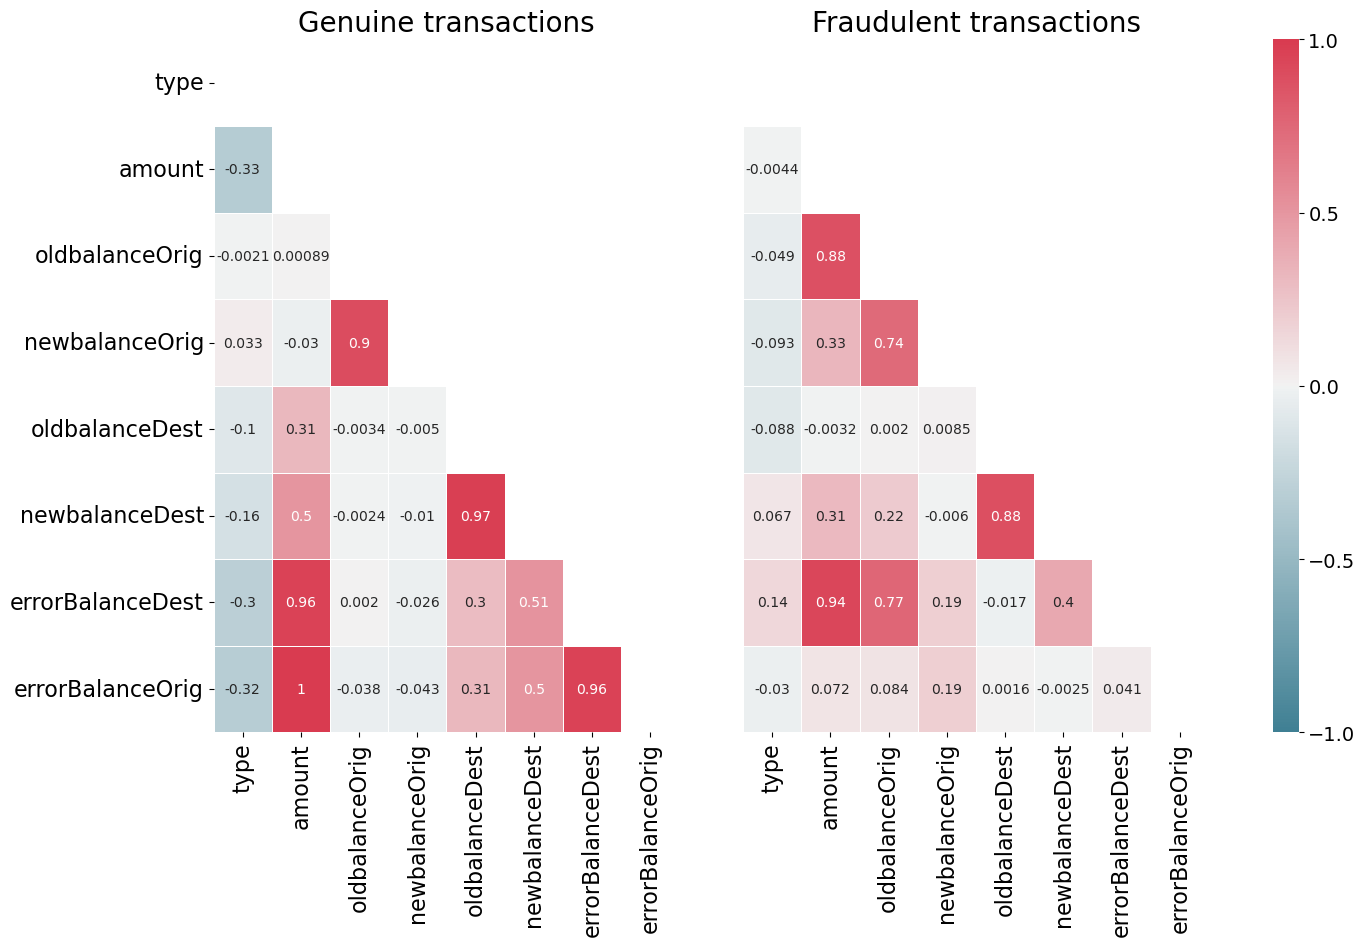

In [94]:
X_fraud = X.loc[y == 1] 
X_nonFraud = X.loc[y == 0]
                  
corrNonFraud = X_nonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(corrNonFraud)
indices = np.triu_indices_from(corrNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
fig, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 = sns.heatmap(corrNonFraud, ax = ax1, vmin = -1, vmax = 1, cmap = cmap, annot=True, 
                 square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16) 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16) 
ax1.set_title('Genuine transactions', size = 20)

corrFraud = X_fraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(corrFraud, vmin = -1, vmax = 1, cmap = cmap, ax = ax2, annot=True, square = False,
                  linewidths = 0.5, mask = mask, yticklabels = False, cbar_ax = cbar_ax,
                  cbar_kws={'orientation': 'vertical', 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16) 
ax2.set_title('Fraudulent transactions', size = 20)

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

> Dispersion over error in balance in destination accounts

In [95]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (10, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, hue = hue, jitter = 0.4, marker = '.', size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, fontsize=16);
    return ax

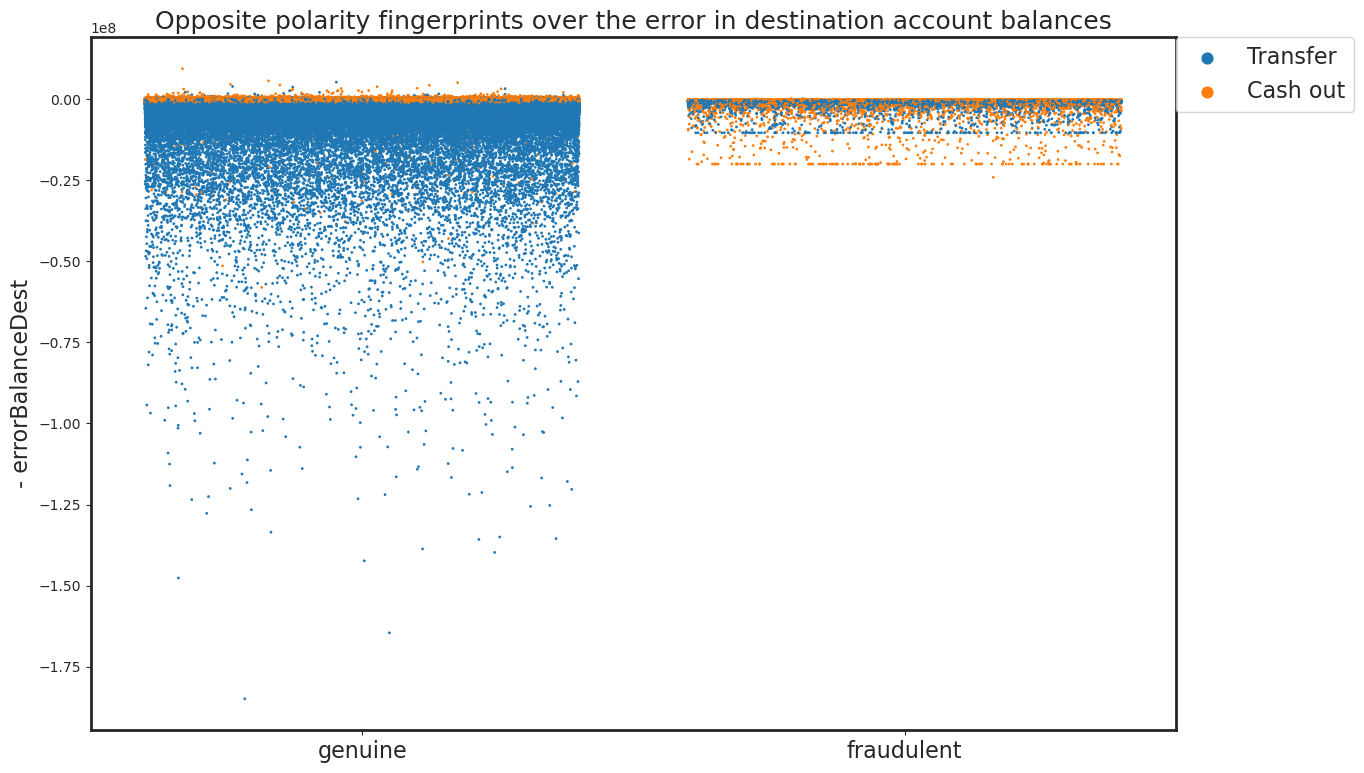

In [96]:
ax = plotStrip(y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in destination account balances', size = 18);

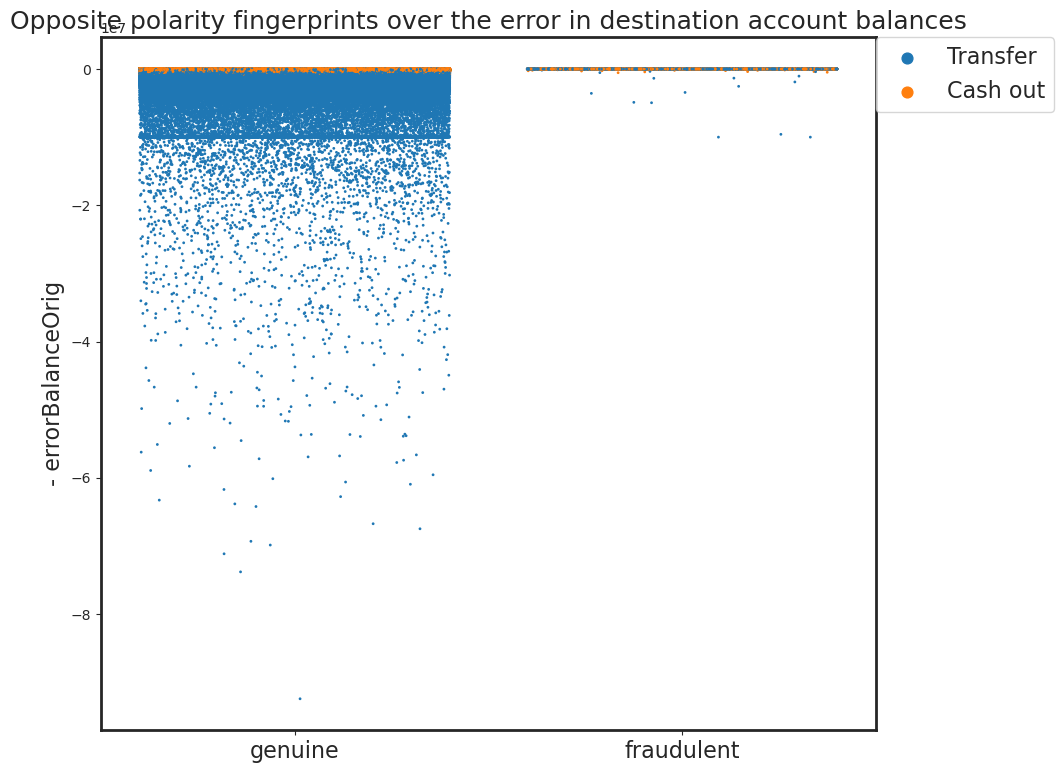

In [97]:
ax = plotStrip(y[:limit], - X.errorBalanceOrig[:limit], X.type[:limit], figsize = (10, 9))
ax.set_ylabel('- errorBalanceOrig', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in destination account balances', size = 18);


### Modelling

 - Having obtained evidence from the plots above that the data now contains features that make fraudulent transactions clearly
  detectable, the remaining obstacle for training a robust ML model is the highly imbalanced nature of the data.

In [98]:
skew = len(X_fraud) / float(len(X))
print(skew)

0.0027907706751010603


- Selection of metric:  
> Since the data is highly skewed, I would use the Area Under The Precision-Recall Curve (AUPRC) rather than the conventional Area Under The Receiver Operating Characteristic (AUROC). This is because the AUPRC is more sensitive to differences between algorithms and their parameter settings rather than the AUROC.

- Selection of ML algorithm: 
>A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, 
say by the Synthetic Minority Oversampling Technique (SMOTE) contained in the 'imblearn' library. 
<!-- > However, the best result was obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. 
> Among these algorithms, the extreme gradient-boosted (XGBoost) algorithm used below slightly outperforms random-forest. Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the data. -->

In [99]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
def objectivelgbm(trial,data=X,target=y):
    # Optuna+cv :
    #https://www.kaggle.com/hamidrezabakhtaki/xgboost-catboost-lighgbm-optuna-final-submission
    # https://www.kaggle.com/prashant111/lightgbm-classifier-in-python
    # https://www.kaggle.com/tunguz/tps-09-21-histgradientboosting-with-optuna
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.01, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 10),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10),
        'n_estimators': 1000,
        'early_stopping_rounds': 10,
        'n_jobs': -1,
        'random_state': 42
    }
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='f1', verbose=False)
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred)
    return score

In [101]:
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objectivelgbm ,n_trials=10)

[I 2023-04-12 21:52:16,356] A new study created in memory with name: no-name-9996eaed-1ae9-4339-9d29-a7d220a99bc9
[I 2023-04-12 21:54:06,038] Trial 0 finished with value: 0.9973509933774835 and parameters: {'num_leaves': 249, 'max_depth': 13, 'learning_rate': 0.0021134537279052764, 'feature_fraction': 0.831648264100973, 'bagging_fraction': 0.23382618675389877, 'bagging_freq': 2, 'min_child_samples': 64, 'min_child_weight': 0.011749005347119014, 'reg_alpha': 0.009681710031805839, 'reg_lambda': 0.026543314672011955, 'scale_pos_weight': 2.0293429592525776}. Best is trial 0 with value: 0.9973509933774835.


[LightGBM] [Warning] feature_fraction is set=0.942323710641756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.942323710641756
[LightGBM] [Warning] bagging_fraction is set=0.9685970014407087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9685970014407087
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


[I 2023-04-12 21:55:43,045] Trial 1 finished with value: 0.9976828864614367 and parameters: {'num_leaves': 58, 'max_depth': 19, 'learning_rate': 0.015004967517403121, 'feature_fraction': 0.942323710641756, 'bagging_fraction': 0.9685970014407087, 'bagging_freq': 5, 'min_child_samples': 57, 'min_child_weight': 2.0490301622719405, 'reg_alpha': 3.170804201731995, 'reg_lambda': 0.001114013105578063, 'scale_pos_weight': 4.434373208939221}. Best is trial 1 with value: 0.9976828864614367.


[LightGBM] [Warning] feature_fraction is set=0.22559070597207792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22559070597207792
[LightGBM] [Warning] bagging_fraction is set=0.9377615319162526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9377615319162526
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


[I 2023-04-12 21:58:13,470] Trial 2 finished with value: 0.9920159680638724 and parameters: {'num_leaves': 241, 'max_depth': 18, 'learning_rate': 0.023434396528865708, 'feature_fraction': 0.22559070597207792, 'bagging_fraction': 0.9377615319162526, 'bagging_freq': 9, 'min_child_samples': 100, 'min_child_weight': 0.011197571628402932, 'reg_alpha': 3.1906215834647442, 'reg_lambda': 0.2238835407942444, 'scale_pos_weight': 4.109541061781112}. Best is trial 1 with value: 0.9976828864614367.


[LightGBM] [Warning] feature_fraction is set=0.15846101773205104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15846101773205104
[LightGBM] [Warning] bagging_fraction is set=0.33771849496756257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33771849496756257
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


[I 2023-04-12 21:58:16,746] Trial 3 finished with value: 0.3580441640378549 and parameters: {'num_leaves': 136, 'max_depth': 3, 'learning_rate': 0.022752811775234937, 'feature_fraction': 0.15846101773205104, 'bagging_fraction': 0.33771849496756257, 'bagging_freq': 6, 'min_child_samples': 7, 'min_child_weight': 0.18411145113445992, 'reg_alpha': 6.860530569462624, 'reg_lambda': 0.0020137344133046927, 'scale_pos_weight': 8.380382628709345}. Best is trial 1 with value: 0.9976828864614367.


[LightGBM] [Warning] feature_fraction is set=0.6470925152528558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6470925152528558
[LightGBM] [Warning] bagging_fraction is set=0.6962740546844545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6962740546844545
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


[I 2023-04-12 22:00:03,692] Trial 4 finished with value: 0.9976828864614367 and parameters: {'num_leaves': 194, 'max_depth': 6, 'learning_rate': 0.006746784541215371, 'feature_fraction': 0.6470925152528558, 'bagging_fraction': 0.6962740546844545, 'bagging_freq': 7, 'min_child_samples': 83, 'min_child_weight': 1.2056185449297079, 'reg_alpha': 0.06742005475921845, 'reg_lambda': 0.01457588908971138, 'scale_pos_weight': 9.101085724554455}. Best is trial 1 with value: 0.9976828864614367.


[LightGBM] [Warning] feature_fraction is set=0.7913927705372681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7913927705372681
[LightGBM] [Warning] bagging_fraction is set=0.42865113707068914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42865113707068914
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


[I 2023-04-12 22:00:19,871] Trial 5 finished with value: 0.9970228250082698 and parameters: {'num_leaves': 113, 'max_depth': 13, 'learning_rate': 0.0532384025035764, 'feature_fraction': 0.7913927705372681, 'bagging_fraction': 0.42865113707068914, 'bagging_freq': 3, 'min_child_samples': 98, 'min_child_weight': 0.507711044370504, 'reg_alpha': 1.866669127882096, 'reg_lambda': 0.0075378378266157285, 'scale_pos_weight': 3.829010391281783}. Best is trial 1 with value: 0.9976828864614367.


[LightGBM] [Warning] feature_fraction is set=0.162033871392601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.162033871392601
[LightGBM] [Warning] bagging_fraction is set=0.8208854396327946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8208854396327946
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


[I 2023-04-12 22:04:16,061] Trial 6 finished with value: 0.8949837603753158 and parameters: {'num_leaves': 235, 'max_depth': 16, 'learning_rate': 0.014764430234251768, 'feature_fraction': 0.162033871392601, 'bagging_fraction': 0.8208854396327946, 'bagging_freq': 6, 'min_child_samples': 64, 'min_child_weight': 0.13377038083707704, 'reg_alpha': 0.001124057731295679, 'reg_lambda': 0.0828245072620342, 'scale_pos_weight': 4.248962856699403}. Best is trial 1 with value: 0.9976828864614367.


[LightGBM] [Warning] feature_fraction is set=0.6551040942876054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6551040942876054
[LightGBM] [Warning] bagging_fraction is set=0.9657906384849201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9657906384849201
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


[I 2023-04-12 22:06:26,459] Trial 7 finished with value: 0.9973509933774835 and parameters: {'num_leaves': 94, 'max_depth': 8, 'learning_rate': 0.0020494703745208573, 'feature_fraction': 0.6551040942876054, 'bagging_fraction': 0.9657906384849201, 'bagging_freq': 6, 'min_child_samples': 87, 'min_child_weight': 0.4171453725614547, 'reg_alpha': 0.6629700921380035, 'reg_lambda': 0.013688774641336148, 'scale_pos_weight': 7.637432886840425}. Best is trial 1 with value: 0.9976828864614367.


[LightGBM] [Warning] feature_fraction is set=0.8565407210463293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8565407210463293
[LightGBM] [Warning] bagging_fraction is set=0.24923497030691188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24923497030691188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


[I 2023-04-12 22:07:31,250] Trial 8 finished with value: 0.9973509933774835 and parameters: {'num_leaves': 9, 'max_depth': 8, 'learning_rate': 0.0050077482110788855, 'feature_fraction': 0.8565407210463293, 'bagging_fraction': 0.24923497030691188, 'bagging_freq': 1, 'min_child_samples': 86, 'min_child_weight': 0.045625096931249706, 'reg_alpha': 1.330540951194373, 'reg_lambda': 0.007816032324100212, 'scale_pos_weight': 9.275658539088548}. Best is trial 1 with value: 0.9976828864614367.


[LightGBM] [Warning] feature_fraction is set=0.7091161701195156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7091161701195156
[LightGBM] [Warning] bagging_fraction is set=0.7213948927306013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7213948927306013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


[I 2023-04-12 22:09:50,985] Trial 9 finished with value: 0.9973509933774835 and parameters: {'num_leaves': 187, 'max_depth': 13, 'learning_rate': 0.0031341970879698476, 'feature_fraction': 0.7091161701195156, 'bagging_fraction': 0.7213948927306013, 'bagging_freq': 1, 'min_child_samples': 22, 'min_child_weight': 0.011866766669493647, 'reg_alpha': 0.0022825973725807036, 'reg_lambda': 0.0028169662689556123, 'scale_pos_weight': 5.158321581273901}. Best is trial 1 with value: 0.9976828864614367.


In [102]:
print("Numbers of finished trials : " , len(study_lgbm.trials))
print("Best Trials : ", study_lgbm.best_trial.params)
print("Best Values : " , study_lgbm.best_value)

Numbers of finished trials :  10
Best Trials :  {'num_leaves': 58, 'max_depth': 19, 'learning_rate': 0.015004967517403121, 'feature_fraction': 0.942323710641756, 'bagging_fraction': 0.9685970014407087, 'bagging_freq': 5, 'min_child_samples': 57, 'min_child_weight': 2.0490301622719405, 'reg_alpha': 3.170804201731995, 'reg_lambda': 0.001114013105578063, 'scale_pos_weight': 4.434373208939221}
Best Values :  0.9976828864614367


In [114]:
lgbm = LGBMClassifier(num_leaves=58, max_depth=19, learning_rate=0.015004967517403121, 
                    feature_fraction=0.942323710641756, bagging_fraction=0.9685970014407087, bagging_freq=5, 
                    min_child_samples=57, min_child_weight=2.0490301622719405, reg_alpha=3.170804201731995, 
                    reg_lambda=0.001114013105578063, scale_pos_weight=4.434373208939221)
prob = lgbm.fit(X_train, y_train).predict(X_val)
print('F1_score = {}'.format(f1_score(y_val, prob)))

[LightGBM] [Warning] feature_fraction is set=0.942323710641756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.942323710641756
[LightGBM] [Warning] bagging_fraction is set=0.9685970014407087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9685970014407087
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
F1_score = 0.9973509933774835


In [115]:
# define the custom F1 score function
def f1(preds, y_true):
    y_pred = np.round(preds)
    return 'f1', f1_score(y_true, y_pred), True

def objectivexgb(trial, data=X, target=y):
    # define the hyperparameters to optimize
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'verbosity': 0,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eta': trial.suggest_loguniform('eta', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma'
        
        
        
        
        
        
        , 0, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-6, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-6, 10)
    }
    
    # train and evaluate the model with the given hyperparameters
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred.round())
    return score


In [105]:
# create and run the optimization study
study = optuna.create_study(direction='maximize')
study.optimize(objectivexgb, n_trials=10)

[I 2023-04-12 22:10:22,090] A new study created in memory with name: no-name-1f7d32e2-2091-4df2-a063-9779b4242560
[I 2023-04-12 22:12:06,255] Trial 0 finished with value: 0.038860103626943004 and parameters: {'eta': 0.011587842829946285, 'max_depth': 6, 'min_child_weight': 0.28146363814772996, 'subsample': 0.7847466786053647, 'colsample_bytree': 0.1663294950697236, 'gamma': 6.054745279375683, 'reg_alpha': 3.0598234103218513e-06, 'reg_lambda': 3.5985214772737235e-05}. Best is trial 0 with value: 0.038860103626943004.
[I 2023-04-12 22:14:32,047] Trial 1 finished with value: 0.612282309807516 and parameters: {'eta': 0.00011277946460818359, 'max_depth': 6, 'min_child_weight': 0.17580361549431087, 'subsample': 0.8606103233643384, 'colsample_bytree': 0.35104516766768856, 'gamma': 9.291866088320647, 'reg_alpha': 0.012074917328339754, 'reg_lambda': 0.0020757636137078237}. Best is trial 1 with value: 0.612282309807516.
[I 2023-04-12 22:16:14,386] Trial 2 finished with value: 0.8017411950929956 

In [106]:
print("Numbers of finished trials : " , len(study.trials))
print("Best Trials : ", study.best_trial.params)
print("Best Values : " , study.best_value)

Numbers of finished trials :  10
Best Trials :  {'eta': 0.0010253479779888947, 'max_depth': 5, 'min_child_weight': 0.1118400136026022, 'subsample': 0.606145861626158, 'colsample_bytree': 0.8782767351342554, 'gamma': 6.962855106056299, 'reg_alpha': 0.001761248631495118, 'reg_lambda': 0.013492638570837835}
Best Values :  0.997020854021847


In [116]:
xgb = XGBClassifier(eta=0.0010253479779888947, max_depth=5, min_child_weight=0.1118400136026022, 
                    subsample=0.606145861626158, colsample_bytree=0.8782767351342554, gamma=6.962855106056299, 
                    reg_alpha=0.001761248631495118, reg_lambda=0.013492638570837835)
pred = xgb.fit(X_train, y_train).predict(X_val)
print('F1_score = {}'.format(f1_score(y_val, pred)))

F1_score = 0.997020854021847


> What are the important features for the ML model?

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

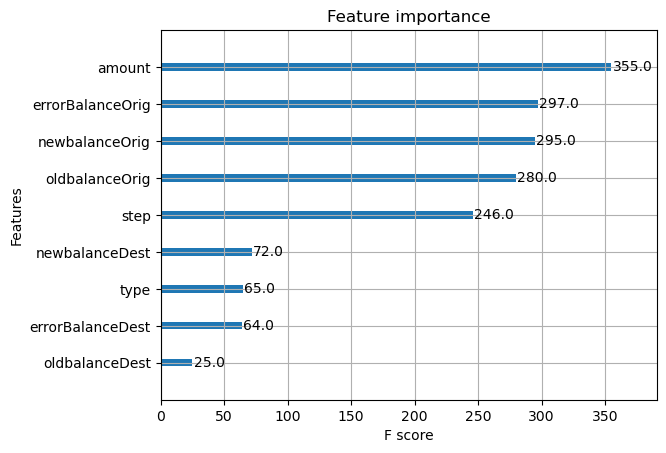

In [108]:
plot_importance(xgb, max_num_features=10)

> Visualizing the model

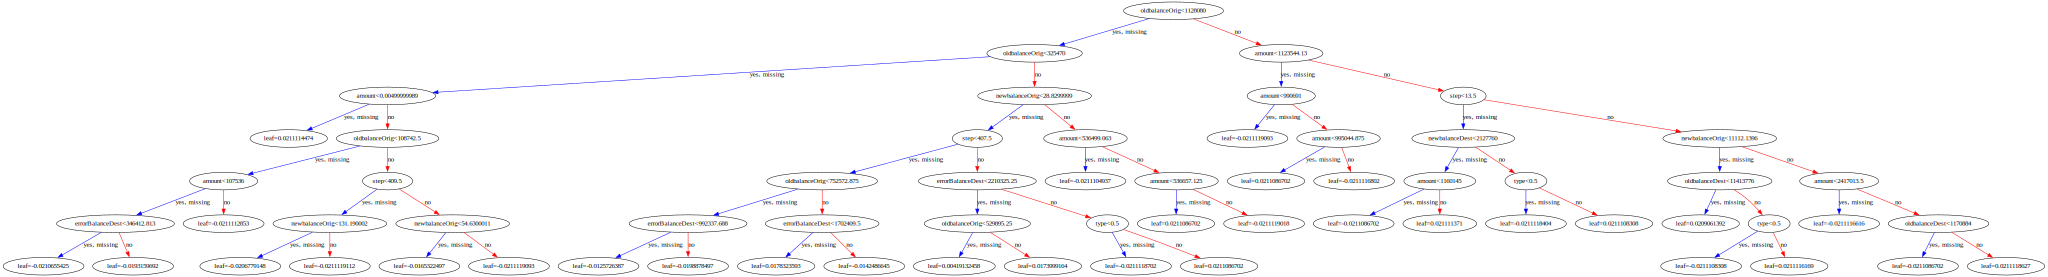

In [109]:
to_graphviz(xgb)

> Saving the models

In [125]:
joblib.dump(lgbm, 'lgbm_model.joblib')

joblib.dump(xgb, 'xgb_model.joblib')

['xgb_model.joblib']

> Testing the model

In [117]:
X.head()

,step,type,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceDest,errorBalanceOrig
2,1,0,181.00,181.0,0.0,1.704323e+06,2.050631e+06,3.464895e+05,0.00
3,1,1,181.00,181.0,0.0,2.118200e+04,0.000000e+00,-2.100100e+04,0.00
15,1,1,229133.94,15325.0,0.0,5.083000e+03,5.151344e+04,2.755644e+05,213808.94
19,1,0,215310.30,705.0,0.0,2.242500e+04,0.000000e+00,1.928853e+05,214605.30
24,1,0,311685.89,10835.0,0.0,6.267000e+03,2.719173e+06,3.024592e+06,300850.89


In [122]:
data = [[1, 0, 235846.00, 375000.0, 0.0, 25000.0, 75470.0, 286316.00, -139154.00]]
# Define the column names
columns = ['step', 'type', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceDest', 'errorBalanceOrig']

# Create a new DataFrame with the same column names
input_df = pd.DataFrame(data, columns=columns)

# Make the prediction
proba = lgbm.predict_proba(input_df)
proba

array([[0.21334899, 0.78665101]])

In [124]:
data = [[1, 0, 235846.00, 375000.0, 139154.0, 25000.0, 260846.0, 471692.00, 0.00]]
# Define the column names
columns = ['step', 'type', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceDest', 'errorBalanceOrig']

# Create a new DataFrame with the same column names
input_df = pd.DataFrame(data, columns=columns)

# Make the prediction
proba = lgbm.predict_proba(input_df)
proba

array([[0.99892792, 0.00107208]])